In [347]:
import numpy as np
import pandas as pd
from pyproj import Geod
import datetime
from matplotlib import pyplot as plt

In [336]:
train_data = pd.read_csv( "../input/train.csv" )
test_data = pd.read_csv( "../input/test.csv" )

In [337]:
# Utiliy functions

#Get distance between pairs of lat-lon points
wgs84_geod = Geod(ellps='WGS84')
def get_distance(lat1,lon1,lat2,lon2):
    az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2)
    return dist

# Convert time object to seconds
def to_seconds(time):
    return (time.hour * 60 + time.minute) * 60 + time.second

In [338]:
def process_data(data):
    # Calculating distance (m) based on longitude/latituides and adding it in a new column 'dist'
    data['dist'] = get_distance(data['pickup_latitude'].tolist(), data['pickup_longitude'].tolist(),
                                      data['dropoff_latitude'].tolist(), data['dropoff_longitude'].tolist())

    # Replacing N of store_and_fwd_flag with 0 and Y with 1
    data = data.replace({'N': 0, 'Y': 1})

    # Extracting day and time from 'pickup_datetime' column and adding them as 2 new columns
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
    new_dates, new_times, is_weekend = zip(*[(d.weekday(), d.time().hour) for d in data['pickup_datetime']])
    data = data.assign(pickup_day=new_dates, pickup_hour=new_times)

    
    
    
    # Dropping columns no longer required
    data = data.drop(['pickup_latitude','pickup_longitude', 'pickup_datetime',
                      'dropoff_latitude','dropoff_longitude', 'id', 'store_and_fwd_flag'], axis=1)

    return (data - data.mean()) / data.std()  # Normalizing our data

In [339]:
# Hypothesis function
def hyp(theta, X):
    return np.dot(X, theta.T)  

# The loss function in our case is the sum of the squared error
def loss_func(theta, X, Y):
    return np.sum(((hyp(theta, X) - Y)**2) / (2 * X.shape[0]))

def get_graident(theta, X, Y):
    derivatives = []
  
    for i in range(0, X.shape[1]):
        derivatives.append(np.sum((hyp(theta, X) - Y) * X[:, i]) / X.shape[0])

    return np.array(derivatives)


def gradient_descent(X, Y, maxniter=20000):
    thetas = np.random.rand(X.shape[1],)
    alpha = 0.001
    costs = []
    
    for i in range(0, maxniter):
        thetas = thetas - (alpha * get_graident(thetas, X, Y))
        costs.append(loss_func(thetas, X, Y))
        
    return thetas, costs

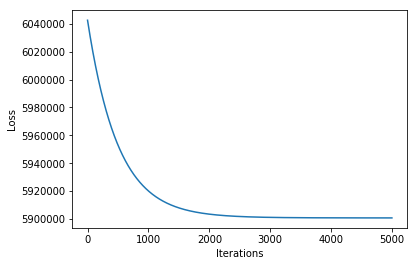

In [340]:
X = train_data.drop('trip_duration', axis=1)
X = process_data(X).values
Y = train_data['trip_duration'].values

max_iters = 5000
thetas, costs = gradient_descent(X, Y, max_iters)

plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.plot(np.arange(0, max_iters), costs)

In [341]:
test_data_proc = process_data(test_data)

In [342]:
pred = np.dot(test_data_proc, thetas)
pred = np.absolute(pred)
pred = pred.astype(int)

submission = pd.DataFrame({'id':test_data['id'],'trip_duration':pred})
submission.to_csv("submission.csv", index=False)
submission

,id,trip_duration
0,id1430318,82
1,id3276964,223
2,id2541342,115
3,id3582288,444
4,id2976277,570
5,id1856113,60
6,id0712136,131
7,id2704634,4
8,id2736446,485
9,id3267520,137


In [370]:
train_data.trip_duration.describe()

count    30000.000000
mean       962.017833
std       3340.870179
min          2.000000
25%        396.000000
50%        660.000000
75%       1070.000000
max      86340.000000
Name: trip_duration, dtype: float64

In [375]:
# Removing outliers
train_data[train_data.trip_duration <= np.percentile(train_data.trip_duration, 99)].trip_duration.describe()

count    29701.000000
mean       805.734824
std        574.731931
min          2.000000
25%        394.000000
50%        655.000000
75%       1053.000000
max       3423.000000
Name: trip_duration, dtype: float64